In [58]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

 _______________________________________________
# Years of Rock Classification - 2008 to 2015
## # echonest audio features + duration and listens
 _______________________________________________
### 1. Preprocessing

In [59]:
# load data
rock_df = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/Data/Dataset [cleaned]/rock_year_df.csv')
rock_df.set_index('track_id', inplace=True)
rock_df.drop('genre_top',axis=1, inplace=True)
rock_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,year,listens,duration
track_id,,,,,,,,,,,
153,0.992477,0.235523,0.979996,0.979732,0.101517,0.029958,0.276730,0.020248,2008,424,405
154,0.974230,0.347646,0.023585,0.963730,0.092975,0.009158,0.111624,0.021913,2008,205,319
155,0.985801,0.104813,0.912310,0.973981,0.357482,0.068009,0.284293,0.020565,2008,197,756
169,0.993317,0.201312,0.722926,0.264895,0.070895,0.031730,0.295199,0.014398,2008,270,144
170,0.890402,0.284917,0.744434,0.927317,0.120801,0.069343,0.311301,0.061032,2008,122,181


In [60]:
rock_df.year.value_counts()

2009    1036
2008    1005
2010     687
2011     606
2012     213
2013     142
2014     132
2015      71
Name: year, dtype: int64

In [61]:
rock_df.shape

(3892, 11)

In [62]:
pd.concat([rock_df.year.value_counts(),
                round(rock_df.year.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
2009,1036,26.62
2008,1005,25.82
2010,687,17.65
2011,606,15.57
2012,213,5.47
2013,142,3.65
2014,132,3.39
2015,71,1.82


In [63]:
rock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3892 entries, 153 to 124186
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      3892 non-null   float64
 1   danceability      3892 non-null   float64
 2   energy            3892 non-null   float64
 3   instrumentalness  3892 non-null   float64
 4   liveness          3892 non-null   float64
 5   speechiness       3892 non-null   float64
 6   tempo             3892 non-null   float64
 7   valence           3892 non-null   float64
 8   year              3892 non-null   int64  
 9   listens           3892 non-null   int64  
 10  duration          3892 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 364.9 KB


In [64]:
# convert year from integer to string
rock_df.year = rock_df.year.astype(str)

In [65]:
rock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3892 entries, 153 to 124186
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      3892 non-null   float64
 1   danceability      3892 non-null   float64
 2   energy            3892 non-null   float64
 3   instrumentalness  3892 non-null   float64
 4   liveness          3892 non-null   float64
 5   speechiness       3892 non-null   float64
 6   tempo             3892 non-null   float64
 7   valence           3892 non-null   float64
 8   year              3892 non-null   object 
 9   listens           3892 non-null   int64  
 10  duration          3892 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 364.9+ KB


In [66]:
# encoding labels
le = preprocessing.LabelEncoder()
rock_df['year'] = le.fit_transform(rock_df['year'])
print('Legend:\n0: 2008\n1: 2009\n2: 2010\n3: 2011\n4: 2012\n5: 2013 \n6: 2014\n7: 2015')
rock_df.year.value_counts()

Legend:
0: 2008
1: 2009
2: 2010
3: 2011
4: 2012
5: 2013 
6: 2014
7: 2015


1    1036
0    1005
2     687
3     606
4     213
5     142
6     132
7      71
Name: year, dtype: int64

In [67]:
# detach target col
labels = rock_df[['year']]
labels.reset_index(drop=True, inplace=True)
labels = labels['year']

In [68]:
# remove labels from dataframe
rock_df.drop('year', axis=1, inplace=True)

In [69]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rock_df)

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot

Text(0.5, 0, 'Principal Component #')

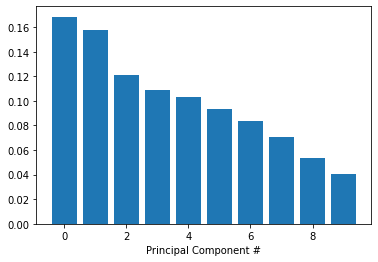

In [70]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### b) cumulative explained variance plot

Optimal number of components: 7
Explained variation per principal component:
[0.16843282 0.15730157]


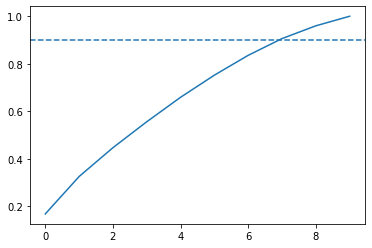

In [97]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

## 2.2 Plot PCA in 2D

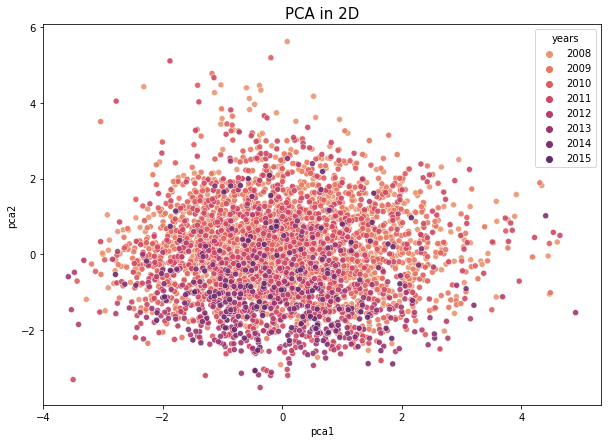

In [72]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['years'] = le.inverse_transform(labels)

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='years',
    palette = 'flare',
    data=df,
    legend='full',
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

### 2.3 Plot PCA in 3D

In [73]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='years',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
),width=700, height=700, scene_camera_eye_z=0.8)
fig.show()


# 3. Split data for classification

In [74]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (split without PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=42,stratify= labels)

In [75]:
# check partitions
print(f"Legend:\n0: 2008\n1: 2009\n2: 2010\n3: 2011\n4: 2012\n5: 2013 \n6: 2014\n7: 2015\n\n\
***PCA***\nDevelopment set:\n{y_develop_pca.value_counts()}\n\nInternal Test:\
\n{y_test_pca.value_counts()}\n\n\-----------------\n\***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

Legend:
0: 2008
1: 2009
2: 2010
3: 2011
4: 2012
5: 2013 
6: 2014
7: 2015

***PCA***
Development set:
1    725
0    704
2    481
3    424
4    149
5     99
6     92
7     50
Name: year, dtype: int64

Internal Test:
1    311
0    301
2    206
3    182
4     64
5     43
6     40
7     21
Name: year, dtype: int64

\-----------------
\***No-PCA***
Development set:
1    725
0    704
2    481
3    424
4    149
5     99
6     92
7     50
Name: year, dtype: int64

Internal Test:
1    311
0    301
2    206
3    182
4     64
5     43
6     40
7     21
Name: year, dtype: int64


# 4. Decision Tree
### a) Unbalanced - without PCA

#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 10 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [78]:
# search parameters
param_grid = {
               "max_depth": [3,4,5,6,7,8,9,10,15, None],
               "min_samples_leaf": [25,20,35,40,45,50,55,75,None],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 25 folds for each of 180 candidates, totalling 4500 fits
best parameters:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 55}
accuracy: 0.32283810037776584
Model with rank: 1
Mean validation score: 0.323 (std: 0.024)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 55}

Model with rank: 2
Mean validation score: 0.323 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 55}

Model with rank: 3
Mean validation score: 0.323 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50}



#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [79]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 55)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.3150684931506849
F1-score [0.40809444 0.37997433 0.23188406 0.18918919 0.16981132 0.32183908
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.41      0.40      0.41       301
           1       0.32      0.48      0.38       311
           2       0.23      0.23      0.23       206
           3       0.25      0.15      0.19       182
           4       0.21      0.14      0.17        64
           5       0.32      0.33      0.32        43
           6       0.00      0.00      0.00        40
           7       0.00      0.00      0.00        21

    accuracy                           0.32      1168
   macro avg       0.22      0.22      0.21      1168
weighted avg       0.29      0.32      0.30      1168



#### Confusion Matrix

[[121 118  50   7   4   1   0   0]
 [ 91 148  45  20   4   3   0   0]
 [ 49  80  48  22   4   3   0   0]
 [ 23  71  52  28   5   3   0   0]
 [  6  20   4  15   9  10   0   0]
 [  1   9   2   6  11  14   0   0]
 [  1  17   4  10   3   5   0   0]
 [  0   5   3   6   2   5   0   0]]


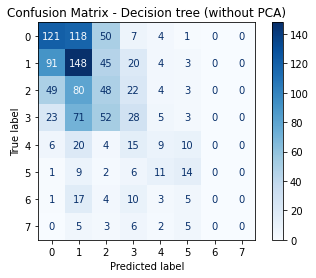

In [81]:
# confusion matrix - Internal Test

cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [82]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

report(clf.cv_results_)

Fitting 25 folds for each of 180 candidates, totalling 4500 fits
best parameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 75}
accuracy: 0.30352698327037236
Model with rank: 1
Mean validation score: 0.304 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 75}

Model with rank: 2
Mean validation score: 0.302 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.302 (std: 0.023)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20}



#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [86]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=4, min_samples_leaf= 75)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Accuracy 0.2054794520547945
F1-score [0.42307692 0.         0.16085791 0.06306306 0.1372549  0.20224719
 0.08465608 0.05524862]
              precision    recall  f1-score   support

           0       0.34      0.55      0.42       301
           1       0.00      0.00      0.00       311
           2       0.18      0.15      0.16       206
           3       0.17      0.04      0.06       182
           4       0.18      0.11      0.14        64
           5       0.13      0.42      0.20        43
           6       0.05      0.20      0.08        40
           7       0.03      0.24      0.06        21

    accuracy                           0.21      1168
   macro avg       0.14      0.21      0.14      1168
weighted avg       0.17      0.21      0.17      1168



#### Confusion matrix

[[184  76  24   8   2   7   0   0]
 [168 105  16  13   1   8   0   0]
 [105  65  20   7   5   4   0   0]
 [ 82  52  27   6   5  10   0   0]
 [  9  12   9   3  12  19   0   0]
 [  5  12   2   1   8  15   0   0]
 [ 10  12   3   4   3   8   0   0]
 [  5   6   2   0   3   5   0   0]]


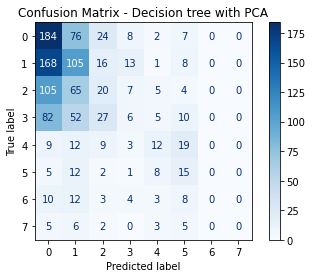

In [84]:
# confusion matrix Decision tree with PCA
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

# 5. KNN
### a) Unbalanced - without PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [85]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 49}
accuracy: 0.31186252023745276


#### Train and predict

In [87]:
knn =  KNeighborsClassifier(n_neighbors = 49)
# retrain knn on the whole development set
knn.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred_knn0))

              precision    recall  f1-score   support

           0       0.36      0.51      0.43       301
           1       0.35      0.51      0.42       311
           2       0.30      0.19      0.24       206
           3       0.19      0.06      0.09       182
           4       0.27      0.27      0.27        64
           5       0.32      0.26      0.29        43
           6       1.00      0.03      0.05        40
           7       0.00      0.00      0.00        21

    accuracy                           0.34      1168
   macro avg       0.35      0.23      0.22      1168
weighted avg       0.33      0.34      0.30      1168



#### Confusion matrix

[[155 100  31   9   5   1   0   0]
 [116 159  22   4   6   4   0   0]
 [ 71  83  40   6   5   1   0   0]
 [ 59  72  30  11   6   4   0   0]
 [ 13  12   4  12  17   6   0   0]
 [  4   5   1  11  11  11   0   0]
 [  5  16   2   4   8   4   1   0]
 [  4   6   2   2   4   3   0   0]]


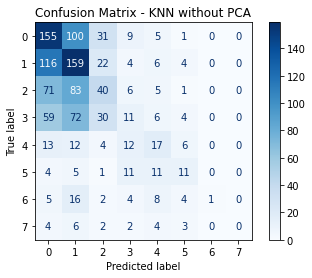

In [88]:
# confusion matrix KNN - Internal test
cm_knn = plot_confusion_matrix(knn,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [95]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 4}
accuracy: 0.31736609552077716


#### Train and predict

In [96]:
knn_pca =  KNeighborsClassifier(n_neighbors = 4)
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))

              precision    recall  f1-score   support

           0       0.30      0.46      0.36       301
           1       0.32      0.33      0.33       311
           2       0.20      0.18      0.19       206
           3       0.19      0.13      0.16       182
           4       0.25      0.14      0.18        64
           5       0.17      0.07      0.10        43
           6       0.20      0.05      0.08        40
           7       0.33      0.10      0.15        21

    accuracy                           0.27      1168
   macro avg       0.25      0.18      0.19      1168
weighted avg       0.26      0.27      0.26      1168



#### Confusion matrix

[[138  90  39  27   6   0   1   0]
 [129 104  52  14   4   2   3   3]
 [ 89  58  37  18   2   2   0   0]
 [ 65  45  37  24   7   2   1   1]
 [ 20   6   6  15   9   7   1   0]
 [  8   9   5  14   2   3   2   0]
 [ 10   7   7   9   4   1   2   0]
 [  3   8   2   3   2   1   0   2]]


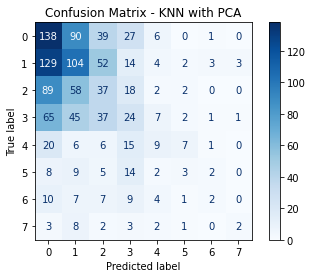

In [91]:
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()
